# Modelo de Detección de Fraude

Durante el siguiente script se detallan e implementan los pasos para la creación de un modelo de detección de fraude a partir de características de cada una de las transacciones registradas.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

In [2]:
pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation


RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = True

# import os

# if(IS_LOCAL):
#     PATH="../input/credit-card-fraud-detection"
# else:
#     PATH="../input"
# print(os.listdir(PATH))

PATH = 'datos_fraud.csv' #definimos la ruta al archivo, en este caso lo tenemos en la misma carpeta.

# Exploratory Data Analysis (EDA)

Nos encargamos de cargar los datos y vemos en que consisten y que columnas podrán ayudarnos a alimentar el modelo.

Se leen los datos

In [3]:
data_df = pd.read_csv(PATH)

El dataset se compone de un identificador unico para cada transacción, una marca de tiempo, un monto de la transacción, 32 variables númericas y un identicador que distingue entre las dos clases a cada registro.

In [4]:
data_df.head()

,transaction_id,timestamp,amount,variable_01,variable_02,variable_03,variable_04,variable_05,variable_06,variable_07,variable_08,variable_09,variable_10,variable_11,variable_12,variable_13,variable_14,variable_15,variable_16,variable_17,variable_18,variable_19,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,variable_29,variable_30,variable_31,variable_32,is_fraud
0,99899e9e02c4b41fc442744220e6fa12f8d36b26f70027...,155270.0,12.00,-0.071330,-0.032900,0.109989,0.339889,-0.626131,-0.116853,1.220826,0.394041,0.051705,0.700084,-1.185263,-0.183050,1.051029,0.267423,-0.220569,1.358207,-0.321922,-1.121246,0.852400,-0.635935,-0.445327,-0.251412,-0.989219,-0.168169,-1.054944,-1.603176,-0.616640,2.283078,0.373964,1.576543,-0.941557,-0.105280,0
1,d678605da2ed45d14c95228b2e6a0daa1c635c7c5d3f7c...,46054.0,208.89,0.057858,0.003669,0.076745,0.392782,0.458835,-0.279094,0.435257,0.230350,0.292049,0.624199,0.327219,-0.032708,-0.372193,1.440826,-0.049183,-0.595081,0.376050,-0.518996,-1.245331,2.034140,-0.073293,-0.439827,-0.863551,-1.606923,-1.100937,0.597263,-1.228029,0.875399,0.260934,-0.558290,0.763729,0.011740,0
2,5f178ebbecf592c3ea98b5b26ff3547f8a40e88aa428d5...,167866.0,1.00,-0.002449,0.019520,-0.038565,0.400659,-1.214922,-0.177434,0.303247,0.030461,-0.112687,-0.307426,1.595186,1.385215,1.068869,1.133506,-2.619782,0.277352,-0.512077,-0.713025,-1.201109,0.561721,-0.351699,0.362076,-1.215083,1.044934,0.533274,-2.802382,0.570268,2.121604,-0.131120,1.603304,-0.032323,0.062465,0
3,455543a8012484e430efd18300186319bf8da376811333...,163539.0,15.00,-0.039202,-0.031762,-0.328682,-0.045094,0.606368,0.204822,0.014322,0.013439,0.016800,0.861519,-0.891606,1.139910,1.179129,-0.795164,-1.056983,-0.142009,-0.026496,1.408220,0.446607,-0.791305,-0.159512,-0.300838,-0.787018,0.020468,-0.853713,-1.915028,-0.478400,2.161957,-1.117518,1.768693,-0.517470,-0.101639,0
4,d8637ef4c5c833fee92149b5b8ef2fad601196be9b7c89...,153872.0,0.01,-0.058206,-0.051926,0.653525,-0.387901,0.806301,0.227390,0.676840,0.209482,-0.206405,0.367224,0.721541,-0.713888,0.496167,0.629590,0.325217,-0.947716,0.513088,0.854643,-0.175665,1.449330,0.141885,-0.854064,-0.347373,-0.750013,-0.914675,-0.595874,-0.705751,2.026529,2.221984,0.744251,-0.768323,-0.166163,0


In [5]:
# Vemos los tipos de datos de cada una de las columnas del dataframe
data_df.describe()

,timestamp,amount,variable_01,variable_02,variable_03,variable_04,variable_05,variable_06,variable_07,variable_08,variable_09,variable_10,variable_11,variable_12,variable_13,variable_14,variable_15,variable_16,variable_17,variable_18,variable_19,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,variable_29,variable_30,variable_31,variable_32,is_fraud
count,284807.000000,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,88.349619,-1.247286e-16,-3.675372e-16,1.687909e-15,5.135217e-16,4.471943e-15,2.633534e-16,-3.505225e-16,1.626624e-16,6.452607e-16,1.037596e-15,9.708849e-16,-3.755206e-16,1.434136e-15,4.887206e-15,1.210587e-15,8.243889e-16,-1.247361e-15,1.699373e-15,2.236932e-15,-2.411096e-15,1.147618e-16,-5.633807e-16,1.497617e-15,1.007309e-15,2.095151e-15,-1.401416e-15,3.384974e-16,1.177057e-15,5.730855e-15,2.153892e-15,-1.611056e-15,-1.168774e-15,0.001727
std,47488.145955,250.120109,3.300833e-01,4.036325e-01,4.822270e-01,5.212781e-01,6.056471e-01,6.244603e-01,7.257016e-01,7.345240e-01,7.709250e-01,8.140405e-01,8.381762e-01,8.493371e-01,8.762529e-01,9.153160e-01,9.585956e-01,9.952742e-01,9.992014e-01,1.020713e+00,1.088850e+00,1.098632e+00,1.194353e+00,1.237094e+00,1.332271e+00,1.380247e+00,1.415869e+00,1.516255e+00,1.651309e+00,1.958696e+00,1.639572e+00,1.314379e+00,4.357099e+00,1.291624e+00,0.041527
min,0.000000,0.000000,-1.543008e+01,-2.256568e+01,-2.604551e+00,-1.029540e+01,-2.836627e+00,-4.480774e+01,-1.093314e+01,-3.483038e+01,-5.449772e+01,-7.213527e+00,-9.498746e+00,-2.516280e+01,-1.412985e+01,-4.498945e+00,-1.921433e+01,-5.791881e+00,-1.868371e+01,-4.797473e+00,-2.458826e+01,-1.343407e+01,-7.321672e+01,-4.355724e+01,-2.616051e+01,-1.137433e+02,-5.683171e+00,-4.832559e+01,-7.271573e+01,-5.640751e+01,-8.855472e+00,-2.119478e+01,-2.036771e+02,-7.221017e+01,0.000000
25%,54201.500000,5.600000,-5.295979e-02,-7.083953e-02,-3.269839e-01,-3.171451e-01,-3.545861e-01,-1.618463e-01,-5.423504e-01,-2.283949e-01,-2.117214e-01,-4.562989e-01,-4.988498e-01,-4.837483e-01,-4.680368e-01,-5.828843e-01,-4.255740e-01,-6.485393e-01,-4.055715e-01,-7.624942e-01,-5.354257e-01,-6.430976e-01,-2.086297e-01,-5.540759e-01,-7.682956e-01,-6.915971e-01,-8.486401e-01,-8.903648e-01,-5.985499e-01,-9.203734e-01,-1.111745e+00,-7.020552e-01,-6.990693e-01,-2.266865e-01,0.000000
50%,84692.000000,22.000000,1.124383e-02,1.342146e-03,-5.213911e-02,1.659350e-02,4.097606e-02,-1.119293e-02,6.781943e-03,-2.945017e-02,-6.248109e-02,3.734823e-03,-3.636312e-03,-6.567575e-02,6.641332e-02,4.807155e-02,5.060132e-02,-1.356806e-02,1.400326e-01,-3.275735e-02,-9.291738e-02,-5.142873e-02,2.235804e-02,4.010308e-02,-2.741871e-01,-5.433583e-02,-1.984653e-02,1.798463e-01,6.548556e-02,1.810880e-02,-1.772730e-01,9.961998e-02,1.484186e-01,4.294867e-03,0.000000
75%,139320.500000,77.165000,7.827995e-02,9.104512e-02,2.409522e-01,3.507156e-01,4.395266e-01,1.476421e-01,5.285536e-01,1.863772e-01,1.330408e-01,4.589494e-01,5.008067e-01,3.996750e-01,5.232963e-01,6.488208e-01,4.931498e-01,6.625050e-01,6.182380e-01,7.395934e-01,4.539234e-01,5.971390e-01,3.273459e-01,5.704361e-01,3.985649e-01,6.119264e-01,7.433413e-01,1.027196e+00,8.037239e-01,1.315642e+00,8.192374e-01,7.849445e-01,1.033295e+00,2.913444e-01,0.000000
max,172792.000000,25691.160000,3.384781e+01,3.161220e+01,3.517346e+00,7.519589e+00,4.584549e+00,2.252841e+01,1.050309e+01,2.720284e+01,3.942090e+01,5.591971e+00,5.041069e+00,9.253526e+00,1.731511e+01,8.877742e+00,1.052677e+01,7.126883e+00,7.848392e+00,1.201891e+01,2.374514e+01,1.559499e+01,2.000721e+01,1.205895e+02,7.330163e+0

Como vimos en el output anterior, el dataframe esta compuesto por cinco tipos de columnas, de las cuales:

- transaction_id: se trata de un identificador que nos ayuda a diferencias cada conjunto de caracteristicas asociado a un registro
- time_stamp: para nuestro modelo, podemos omitir esta columna pues la hora y fecha en la que se realizo la transacción no afecta necesariamente para saber si es o no un fraude.
- amount: la cantidad de credito que se maneje puede ser importante para el analisis, pues a una cantidad mayor de monto podemos interpretar que podría existir mayor riesgo de fraude.
- variables 1  a la 32: variables propias de la transaccion que nos ayudan directamente como entrada para nuestro modelo. Al ser un ejercicio el significado independiente de cada una de estas variables no es de importancia.
- is_fraud: es la etiqueta con la que sabremos si la transacción es un fraude o no.

Verificamos valores perdidos

In [6]:
total = data_df.isnull().sum().sort_values(ascending = False) #con isnull() mapea los datos nulos o nan a true y todos los demás datos del df a falso, 
# sum() la suma de los valores de la columna (que sera 0) y crea un diccionario con el nombre de la columna y la cantidad de nulos que tiene
percent = (data_df.isnull().sum()/data_df.count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje']).transpose()

,transaction_id,timestamp,variable_18,variable_19,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,variable_29,variable_30,variable_31,variable_32,variable_17,variable_16,variable_15,variable_06,amount,variable_01,variable_02,variable_03,variable_04,variable_05,variable_07,variable_14,variable_08,variable_09,variable_10,variable_11,variable_12,variable_13,is_fraud
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Porcentaje,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Como vemos, el paso de limpieza de datos podemos omitirlo, ya que nuestro dataset no cuenta con datos nulos o incorrectos. 

Datos desbalanceados

Al analizar un dataset como este, podremos encontrarnos con que existe cierto desbalanceo entre las clases, es decir, el número de transacciones fraudulentas es mucho menor que las típicas. Esto siguiendo el hecho de que en un problema real así es como se comportaria.

In [7]:
temp = data_df["is_fraud"].value_counts() #cuenta la cantidad para cada uno de valores que existen en la columna
temp.head()

is_fraud
0    284315
1       492
Name: count, dtype: int64

In [8]:
df = pd.DataFrame({'is_fraud': temp.index,'values': temp.values})
#creamos un df exclusivo para representar la cantidad de transacciones fraudulentas contra las que no

trace = go.Bar(
    x = df['is_fraud'],y = df['values'],
    name="Clase Fraude contra Clase Típica - Desbalanceo de datos (Típica = 0, Fraude = 1)",
    marker=dict(color="Blue"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Clase Fraude contra Clase Típica - Desbalanceo de datos (Típica = 0, Fraude = 1)',
          xaxis = dict(title = 'Clase', showticklabels=True), 
          yaxis = dict(title = 'Número de transacciones'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

En este sentido, podemos encontrarnos con varias posibles soluciones al desbalanceo:

* Modificar el dataset: Eliminar datos de la clase típica a partir de un submuestro para igualar la cantidad de muestras en cada clase. La clara desventaja de este enfoque recae en que la perdida de datos es muy grande.

* Creación de datos artificiales: Crear muestras artificiales, agrandando el conjunto de la clase minoritaria. Procediendo asi sobre esta podemos llegar a alterar la distribución original de los datos y provocar que nuestro modelo sea inutil para crear clasificaciones en un entorno real.

* Balanced Ensemble Method: Combina los resultados de varios modelos del data set y asi obtener la clasificación más 'votada' entre estos.


In [9]:
SUB_MUESTREO = True
if SUB_MUESTREO:  
    class_0 = data_df.loc[data_df['is_fraud'] == 0]# trae todos los registros que no son fraudes
    class_1 = data_df.loc[data_df['is_fraud'] == 1]# trae todos los registros que son fraudes
    class_0 = class_0.sample(frac = class_1.shape[0] / class_0.shape[0], replace= False)

    data_df = pd.concat([class_0, class_1 ])

    temp = data_df["is_fraud"].value_counts() #cuenta la cantidad para cada uno de valores que existen en la columna
    temp.head()

    df = pd.DataFrame({'is_fraud': temp.index,'values': temp.values})
    #creamos un df exclusivo para representar la cantidad de transacciones fraudulentas contra las que no

    trace = go.Bar(
        x = df['is_fraud'],y = df['values'],
        name="Clase Fraude contra Clase Típica - Desbalanceo de datos (Típica = 0, Fraude = 1)",
        marker=dict(color="Blue"),
        text=df['values']
    )
    data = [trace]
    layout = dict(title = 'Clase Fraude contra Clase Típica - Desbalanceo de datos (Típica = 0, Fraude = 1)',
            xaxis = dict(title = 'Clase', showticklabels=True), 
            yaxis = dict(title = 'Número de transacciones'),
            hovermode = 'closest',width=600
            )
    fig = dict(data=data, layout=layout)
    iplot(fig, filename='class')

Transacciones en el tiempo

In [10]:
data_df.loc[data_df['is_fraud'] == 0]["timestamp"]

86847      59283.0
135783    122323.0
190267    120946.0
197504    133527.0
117248     44783.0
            ...   
269622    111838.0
128147     65247.0
179995     63967.0
43789      46398.0
143494     50015.0
Name: timestamp, Length: 492, dtype: float64

In [11]:
class_0 = data_df.loc[data_df['is_fraud'] == 0]["timestamp"]# trae todos los registros que no son fraudes, pero solo su timestamp
class_1 = data_df.loc[data_df['is_fraud'] == 1]["timestamp"]# trae todos los registros que son fraudes, peor solo su timestamp

hist_data = [class_0, class_1]
group_labels = ['Típica', 'Fraude']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Diagrama de densidad de transacciones contra tiempo', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

In [12]:
data_df['Hour'] = data_df['timestamp'].apply(lambda x: np.floor(x / 3600))#se crea un nuevo campo hora que divide el time stamp en horas 


In [13]:

tmp = data_df.groupby(['Hour', 'is_fraud'])['amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
# agrupa por hora y por clase, saca solo el monto y genera las funciones de agregacion 
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.89,281.15,7,415.09,59.298571,30.380,10053.707914
1,0.0,1,0.00,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.00,176.94,5,300.18,60.036000,43.290,5218.638230
3,1.0,1,59.00,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,10.43,169.20,6,304.08,50.680000,23.190,3722.244560


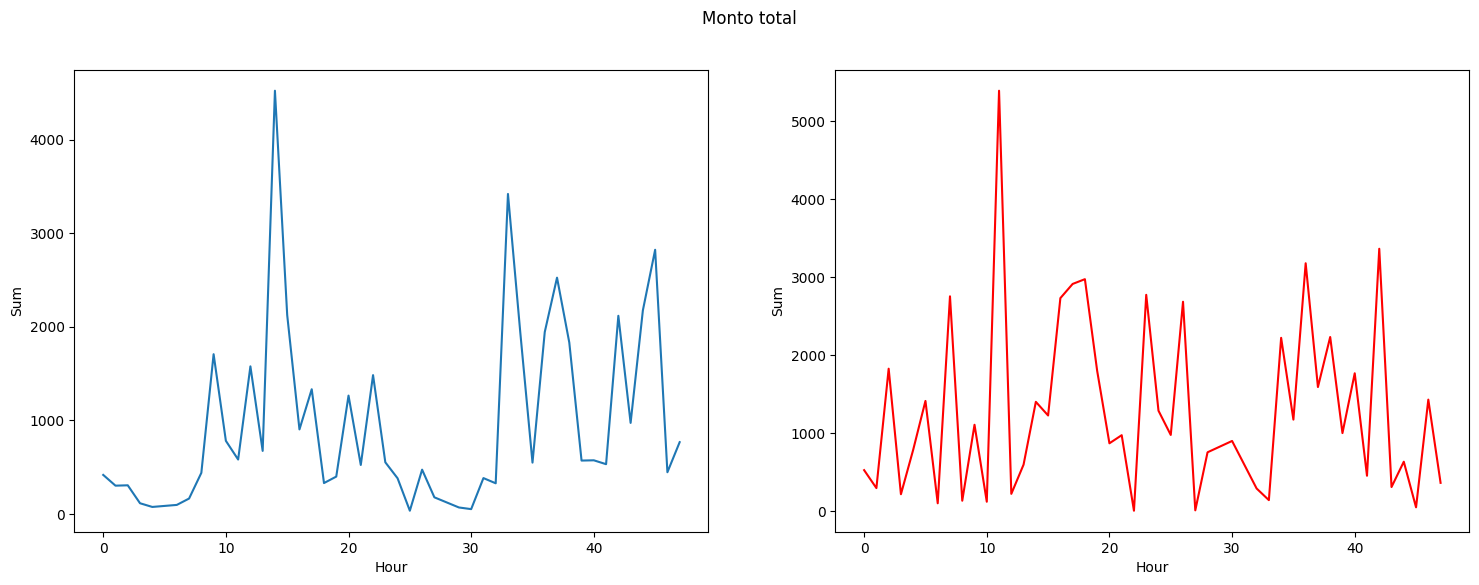

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Monto total")
plt.show();

# Correlación entre las variables:

La correlación entre un par de variables se sustenta en la relación entre ambas. Se dice que si una variale X crece conforme crece una variable Y lo hace, ambas tienen una correlación positiva. Caso contrario si una variable X decrece en relación a una variable Y tienen un correlación negativa. Si en general, no parece haber relación entre las variables y parece que estas fueran en comportamiento independientes una de la otra, entonces las variables no estan correlacionadas.

A continuación se muestra una matriz de correlación entre cada una de las variables del dataset.

In [15]:
#plt.figure(figsize = (14,14))
#plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.loc[:, data_df.columns != 'transaction_id'].corr('pearson')
#sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
corr.style.background_gradient(cmap='coolwarm')
#plt.show()

,timestamp,amount,variable_01,variable_02,variable_03,variable_04,variable_05,variable_06,variable_07,variable_08,variable_09,variable_10,variable_11,variable_12,variable_13,variable_14,variable_15,variable_16,variable_17,variable_18,variable_19,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,variable_29,variable_30,variable_31,variable_32,is_fraud,Hour
timestamp,1.000000,0.046530,0.001794,-0.130844,-0.065876,-0.197454,-0.018202,0.068424,0.122959,-0.051625,-0.007364,-0.073541,0.242624,0.230417,0.237406,-0.179794,0.165627,-0.118548,0.253903,-0.296960,0.205372,0.142811,-0.135672,0.215229,0.107109,0.283054,-0.218112,0.136687,-0.220415,0.238393,-0.065876,0.237406,0.001794,-0.130844,-0.129158,0.999763
amount,0.046530,1.000000,-0.068011,0.054913,-0.035561,-0.098739,0.060926,-0.110851,-0.031379,0.016442,0.191814,0.064284,-0.008609,-0.011979,-0.009080,0.044677,0.048458,-0.019788,0.024586,-0.028925,0.011558,0.014326,0.023429,0.137197,0.163074,-0.106011,-0.015240,-0.005900,-0.247580,-0.020882,-0.035561,-0.009080,-0.068011,0.054913,0.060781,0.045818
variable_01,0.001794,-0.068011,1.000000,0.157651,-0.025138,0.166228,-0.037155,0.076556,-0.219969,0.261556,-0.052986,-0.037627,0.073551,0.054937,0.016482,0.109284,-0.120294,-0.119265,0.007840,0.028684,0.145606,0.157038,-0.024606,0.151880,-0.023139,0.169801,-0.081485,0.127079,-0.020238,0.160437,-0.025138,0.016482,1.000000,0.157651,0.066266,0.001322
variable_02,-0.130844,0.054913,0.157651,1.000000,0.187553,0.199565,-0.195965,-0.184277,-0.369683,0.367407,-0.118594,0.039654,0.055481,0.002171,-0.026877,0.197370,-0.198391,0.048325,-0.022464,0.166439,0.154728,0.135855,0.289712,0.233914,-0.167513,0.188822,-0.024166,0.103283,-0.139422,0.192652,0.187553,-0.026877,0.157651,1.000000,0.077153,-0.132930
variable_03,-0.065876,-0.035561,-0.025138,0.187553,1.000000,0.070135,-0.072240,0.026455,0.003991,0.036515,0.012896,0.034806,-0.009182,-0.041026,-0.050813,0.049144,-0.163711,0.055926,-0.113736,0.149049,-0.026804,-0.093492,0.045227,0.029945,-0.039122,0.079023,0.143222,-0.003076,-0.014345,0.044330,1.000000,-0.050813,-0.025138,0.187553,0.043182,-0.065902
variable_04,-0.197454,-0.098739,0.166228,0.199565,0.070135,1.000000,-0.045973,0.064605,-0.222456,0.138442,0.005009,-0.172640,0.070002,0.039350,0.056731,0.000403,-0.078580,-0.025507,0.034114,0.024780,0.029719,0.004405,0.227391,0.056656,-0.118891,-0.086491,-0.025583,-0.080845,0.117404,-0.075795,0.070135,0.056731,0.166228,0.199565,0.025137,-0.198529
variable_05,-0.018202,0.060926,-0.037155,-0.195965,-0.072240,-0.045973,1.000000,-0.043534,0.070289,-0.043051,-0.024646,0.095841,-0.095828,-0.072385,-0.037284,-0.008861,0.155262,0.013055,0.048569,-0.124801,0.006565,0.026194,0.080639,-0.031933,-0.047373,-0.120475,-0.077504,0.018726,-0.022669,-0.066077,-0.072240,-0.037284,-0.037155,-0.195965,-0.105124,-0.016520
variable_06,0.068424,-0.110851,0.076556,-0.184277,0.026455,0.064605,-0.043534,1.000000,-0.005061,0.127313,0.129052,-0.012292,0.020546,0.019152,0.007225,-0.061461,0.026007,-0.098378,0.016307,-0.033594,-0.045365,-0.044625,-0.432718,-0.086581,0.328653,-0.083721,0.008653,-0.027482,0.132121,-0.050422,0.026455,0.007225,0.076556,-0.184277,-0.027677,0.066421
variable_07,0.122959,-0.031379,-0.219969,-0.369683,0.003991,-0.222456,0.070289,-0.005061,1.000000,-0.759100,0.417109,0.125316,-0.123559,-0.126757,-0.105870,-0.103078,0.061471,0.011094,-0.112453,0.027424,-0.217483,-0.237432,0.039092,-0.121952,0.002204,-0.089196,0.118198,-0.068001,-0.000294,-0.049896,0.003991,-0.105870,-0.219969,-0.369683,0.017119,0.124872
variable_08,-0.051625,0.016442,0.261556,0.367407,0.036515,0.138442,-0.043051,0.127313,-0.759100,1.000000,-0.524010,0.106898,-0.077884,-0.093149,-0.149649,0.144811,-0.221147,-0.008261,-0.074860,0.135219,0.083483,0.159751,-0.114631,0.040600,0.015240,0.042930,-0.019840,0.028850,0.046443,0.014829,0.036515,-0.149649,0.261556,0.367407,0.124932,-0.053806


# Modelos Predictivos

In [16]:
target = 'is_fraud'
predictors = ['timestamp', 'variable_01', 'variable_02', 'variable_03', 'variable_04', 'variable_05', 'variable_06', 'variable_07', 'variable_08', 'variable_09', 'variable_10',\
       'variable_11', 'variable_12', 'variable_13', 'variable_14', 'variable_15', 'variable_16', 'variable_17', 'variable_18', 'variable_19',\
       'variable_20', 'variable_21', 'variable_22', 'variable_23', 'variable_24', 'variable_25', 'variable_26', 'variable_27', 'variable_28',\
       'amount']

In [17]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

# RandomForestClassifier

Un árbol de desición es un algoritmo de aprendizaje supervisado que divide en subconjuntos el dataset de entrada a partir de crear un nodo inicial o raiz, a partir del cual se irán creando nodos hijos a partir de las caracteristicas del dataser. En cada nodo se quedan los subconjuntos que más se ajusten a la caracteristica de ese nodo.

Particiona el conjunto de datos, clasificandolos en clases que son desididas por las reglas de desicion o los diferentes caminos que se pueden tomar desde el nodo raiz hasta alguna de las hojas.

El indice GINI de impureza, nos indica el nivel de impureza de un nodo, es decir, el porcentaje de muestras que se clasifican en este nodo que no corresponden a la clase a la que el nodo debe de apuntar.

En este sentido, los bosques aleatorios se tratan de algoritmos que combinan la funcionalidad y respectivas predicciones de varios árboles que son entrenados cada uno con un subconjunto diferente del dataset y cada uno con predictores diferentes.

Justificación

Los árboles de desición son bien conocidos por implementarse en problemás de clasificación. Cada nodo de la estructura que los compone analiza cada caracteristica de las muestras para "tomar" una desición. Es en este sentido por el que se opta por un RandomForest, una generalización del modelo que permite una mejor robustes y resistencia al sobreajuste.

In [18]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, #cuantos procesos concurrentes o hilos deben de ser utilizados para ejecutar las rutimas paralelizadas 
                             random_state=RANDOM_STATE, 
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [19]:
# Entrenamos el modelo con el conjunto de entrenamiento de características y sus respectivas etiquertas
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [20]:
preds = clf.predict(valid_df[predictors])

In [21]:
# tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
# tmp = tmp.sort_values(by='Feature importance',ascending=False)
# plt.figure(figsize = (7,4))
# plt.title('Importancia de características',fontsize=14)
# s = sns.barplot(x='Característica',y='Importancia',data=tmp)
# s.set_xticklabels(s.get_xticklabels(),rotation=90)
# plt.show()  

In [22]:
#print(preds)
print(valid_df[target].values)
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])

cm

[0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 0
 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1
 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0
 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1
 1 0 0 0 0 0 0 0 1 0]


Predicted,0,1
Actual,,
0,86,3
1,4,65


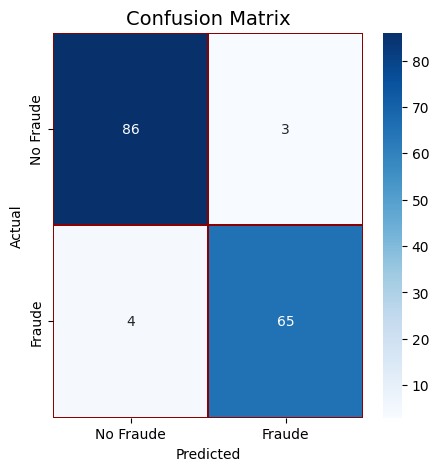

In [23]:

fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['No Fraude', 'Fraude'],
            yticklabels=['No Fraude', 'Fraude'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkred", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [24]:
roc_auc_score(valid_df[target].values, preds)

0.9541605601693535

# Multilayer Perceptron Classifier (Red Neuronal simple)

In [25]:
#from sklearn.neural_network import MLPClassifier
# clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
#                     hidden_layer_sizes=(5, 2), class_weight={0: 0.1, 1: 0.9}, random_state=1)

from modelos.MLP import MLP

nn = MLP(train_df[predictors].to_numpy().shape[1])


In [26]:
# Entrenamos el modelo con el conjunto de entrenamiento de características y sus respectivas etiquertas
weights = {0:1, 1:200}
history = nn.fit(train_df[predictors].to_numpy(), train_df[target].to_numpy(), class_weight=weights, epochs=100, verbose=0)

In [27]:
preds = nn.predict(valid_df[predictors])

5/5 [==============================] - 0s 1ms/step


In [28]:
import math
preds = [(lambda x: math.floor(x) if x < 0.5 else math.ceil(x))(x) for x in preds.reshape(preds.shape[0]).tolist()]

In [29]:
print(valid_df[target].values)
print(preds)

#cm = pd.crosstab(valid_df[target].values, preds.reshape(preds.shape[0]).tolist(), rownames=['Actual'], colnames=['Predicted'])
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
cm

[0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0 0
 1 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1
 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0
 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1
 1 0 0 0 0 0 0 0 1 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Predicted,1
Actual,
0,89
1,69


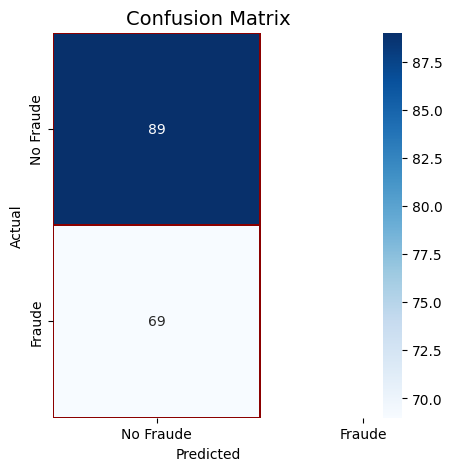

In [30]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['No Fraude', 'Fraude'],
            yticklabels=['No Fraude', 'Fraude'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkred", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [32]:
roc_auc_score(valid_df[target].values, preds)

0.5

# AdaBoostClassifier

In [33]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [34]:
clf.fit(train_df[predictors], train_df[target].values)

C:\Users\MALIERA.ADCONSAR\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [35]:
preds = clf.predict(valid_df[predictors])

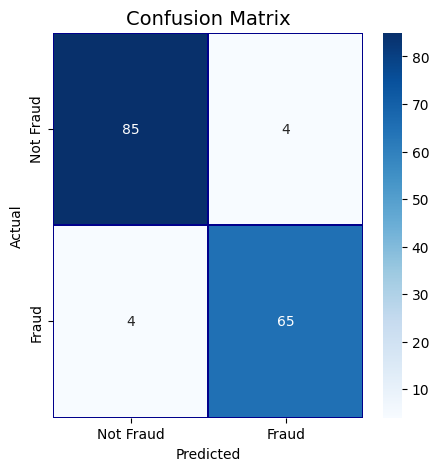

In [36]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [37]:
roc_auc_score(valid_df[target].values, preds)

0.9485425826412637

# CatBoostClassifier

In [38]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [39]:
clf.fit(train_df[predictors], train_df[target].values,verbose=True)

0:	total: 417ms	remaining: 3m 28s
50:	total: 12.4s	remaining: 1m 49s
100:	total: 24.7s	remaining: 1m 37s
150:	total: 36.7s	remaining: 1m 24s
200:	total: 48.4s	remaining: 1m 11s
250:	total: 59.5s	remaining: 59s
300:	total: 1m 11s	remaining: 47.3s
350:	total: 1m 23s	remaining: 35.5s
400:	total: 1m 35s	remaining: 23.6s
450:	total: 1m 47s	remaining: 11.6s
499:	total: 1m 59s	remaining: 0us


In [40]:
preds = clf.predict(valid_df[predictors])

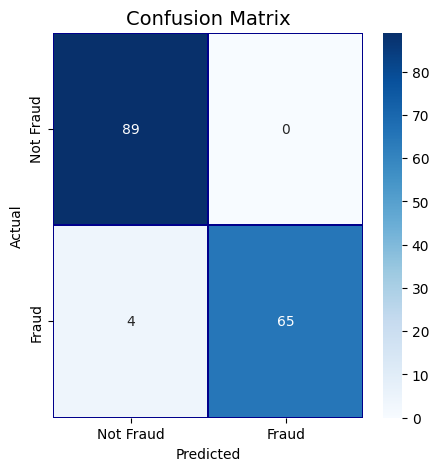

In [41]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [42]:
roc_auc_score(valid_df[target].values, preds)

0.9710144927536232

# XGBoost

In [43]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [44]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.95300	valid-auc:0.95660
[50]	train-auc:0.98902	valid-auc:0.98249


C:\Users\MALIERA.ADCONSAR\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:723: FutureWarning:

Pass `evals` as keyword args.

C:\Users\MALIERA.ADCONSAR\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning:

[12:04:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "silent" } are not used.




[100]	train-auc:0.99414	valid-auc:0.98290
[118]	train-auc:0.99529	valid-auc:0.98241


In [45]:
preds = model.predict(dtest)

In [46]:
roc_auc_score(test_df[target].values, preds)

0.9836116264687693

# LightGBM

In [47]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

In [48]:
dtrain = lgb.Dataset(train_df[predictors].values, 
                     label=train_df[target].values,
                     feature_name=predictors)

dvalid = lgb.Dataset(valid_df[predictors].values,
                     label=valid_df[target].values,
                     feature_name=predictors)

In [52]:
evals_results = {}

model = lgb.train(params, 
                  dtrain, 
                  valid_sets=[dtrain, dvalid], 
                  valid_names=['train','valid'], 
                  #evals_result=evals_results, 
                  num_boost_round=MAX_ROUNDS,
                  #early_stopping_rounds=2*EARLY_STOP,
                  #verbose_eval=VERBOSE_EVAL, 
                  feval=None)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [53]:
preds = model.predict(test_df[predictors])

In [54]:
roc_auc_score(test_df[target].values, preds)

0.9841269841269842